In [1]:
from nlp_tweets.preprocess import clean_text, get_sequences, get_embedding_matrix
from nlp_tweets.model import get_model
from nlp_tweets.eda import plot_roc_curve_mean, get_categorial_confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yannhallouard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
PATH_RAW = '../data/raw/'
PATH_PROCESSED = '../data/processed/'

TRAIN_COLUMNS = ['id', 'text', 'target']
TEST_COLUMNS = ['id', 'text']
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 100

# Loading

In [37]:
tweets_df = pd.read_csv(PATH_RAW + 'train.csv')
tweets_df = tweets_df[TRAIN_COLUMNS]
tweets_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [38]:
tweets_test_df = pd.read_csv(PATH_RAW + 'test.csv')
tweets_test_df = tweets_test_df[TEST_COLUMNS]

# Preprocessing

In [39]:
tweets_df['text'] = tweets_df['text'].map(lambda x: clean_text(x))

In [40]:
data, tokenizer = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, texts=tweets_df['text'])

In [41]:
test_data, _ = get_sequences(vocabulary_size=MAX_NB_WORDS, maxlen=MAX_SEQUENCE_LENGTH, 
                          texts=tweets_test_df['text'], tokenizer=tokenizer)

In [42]:
pretrained_embeddings_path = PATH_RAW + "GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [43]:
embedding_matrix = get_embedding_matrix(tokenizer=tokenizer, 
                                        word2vec=word2vec, 
                                        max_nb_words=MAX_NB_WORDS, 
                                        enbedding_dim=EMBEDDING_DIM)

# Train test split

In [44]:
X_train, X_val, y_train, y_val = train_test_split(data, tweets_df['target'], test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(4567, 100) (2284, 100) (762, 100)


# Create Model

In [63]:
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, GRU, TimeDistributed, \
    Embedding, BatchNormalization, Flatten
from tensorflow.keras.models import Model
import tensorflow
def get_model(vocabulary_size: int, embeding_dim: int, max_sequence_length: int,
              _rnn_nb: [int], _fc_nb: [int], dropout_rate: float) -> tensorflow.keras.models.Model:
    sequence_1_input = Input(shape=(max_sequence_length,), dtype='int32')

    seq = Embedding(vocabulary_size, embeding_dim, input_length=max_sequence_length, trainable=False)(sequence_1_input)
    for _r in _rnn_nb:
        seq = GRU(_r, activation='tanh', dropout=dropout_rate,
                  recurrent_dropout=dropout_rate, return_sequences=True)(seq)

    for _f in _fc_nb:
        seq = TimeDistributed(Dense(_f))(seq)
        seq = Dropout(dropout_rate)(seq)
        seq = TimeDistributed(Dense(_f))(seq)

    seq = Flatten()(seq)
    seq = Dense(100)(seq)
    seq = Activation('tanh')(seq)
    seq = Dropout(dropout_rate)(seq)
    seq = BatchNormalization()(seq)
    seq = Dense(10)(seq)
    seq = Activation('tanh')(seq)
    seq = Dropout(dropout_rate)(seq)
    seq = BatchNormalization()(seq)
    seq = Dense(1)(seq)
    out = Activation('sigmoid', name='strong_out')(seq)

    model = Model(inputs=sequence_1_input, outputs=out)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [64]:
model = get_model(vocabulary_size=MAX_NB_WORDS, embeding_dim=EMBEDDING_DIM, 
                  max_sequence_length=MAX_SEQUENCE_LENGTH,_rnn_nb=[128, 64, 32], _fc_nb=[32], dropout_rate=0.5) 
model.summary()

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
gru_17 (GRU)                 (None, 100, 128)          165120    
_________________________________________________________________
gru_18 (GRU)                 (None, 100, 64)           37248     
_________________________________________________________________
gru_19 (GRU)                 (None, 100, 32)           9408      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 100, 32)           1056      
_________________________________________________________________
dropout_14 (Dropout)         (None, 100, 32)         

# Train

In [65]:
model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
)

Epoch 1/100
72/72 [==============================] - 38s 527ms/step - loss: 0.8236 - accuracy: 0.5310 - val_loss: 1.0176 - val_accuracy: 0.4247
Epoch 2/100
72/72 [==============================] - 37s 508ms/step - loss: 0.7548 - accuracy: 0.5476 - val_loss: 0.6902 - val_accuracy: 0.5753
Epoch 3/100
72/72 [==============================] - 36s 502ms/step - loss: 0.7289 - accuracy: 0.5527 - val_loss: 0.7123 - val_accuracy: 0.5123
Epoch 4/100
72/72 [==============================] - 37s 507ms/step - loss: 0.6909 - accuracy: 0.5752 - val_loss: 0.6432 - val_accuracy: 0.6200
Epoch 5/100
72/72 [==============================] - 36s 505ms/step - loss: 0.6802 - accuracy: 0.5949 - val_loss: 0.7490 - val_accuracy: 0.5753
Epoch 6/100
72/72 [==============================] - 37s 507ms/step - loss: 0.6651 - accuracy: 0.6078 - val_loss: 0.6194 - val_accuracy: 0.6576
Epoch 7/100
72/72 [==============================] - 36s 501ms/step - loss: 0.6449 - accuracy: 0.6381 - val_loss: 0.7186 - val_accuracy:

72/72 [==============================] - 38s 523ms/step - loss: 0.5476 - accuracy: 0.7482 - val_loss: 0.5613 - val_accuracy: 0.7268
Epoch 58/100
72/72 [==============================] - 37s 518ms/step - loss: 0.5371 - accuracy: 0.7526 - val_loss: 0.5938 - val_accuracy: 0.7106
Epoch 59/100
72/72 [==============================] - 38s 524ms/step - loss: 0.5418 - accuracy: 0.7545 - val_loss: 0.5585 - val_accuracy: 0.7290
Epoch 60/100
72/72 [==============================] - 39s 538ms/step - loss: 0.5354 - accuracy: 0.7583 - val_loss: 0.5594 - val_accuracy: 0.7312
Epoch 61/100
72/72 [==============================] - 38s 526ms/step - loss: 0.5385 - accuracy: 0.7510 - val_loss: 0.5671 - val_accuracy: 0.7264
Epoch 62/100
72/72 [==============================] - 37s 518ms/step - loss: 0.5283 - accuracy: 0.7598 - val_loss: 0.5551 - val_accuracy: 0.7338
Epoch 63/100
72/72 [==============================] - 38s 524ms/step - loss: 0.5378 - accuracy: 0.7462 - val_loss: 0.5802 - val_accuracy: 0.708

## Finding the best threshold

In [66]:
pred_proba_train = model.predict(X_train)
pred_proba_val = model.predict(X_val)

Train Accuracy: 0.850886796584191 
Train Confusion Matrix:
[[2423  158]
 [ 523 1463]]
Test Accuracy: 0.7460595446584939 
Test Confusion Matrix:
[[1131  183]
 [ 397  573]]


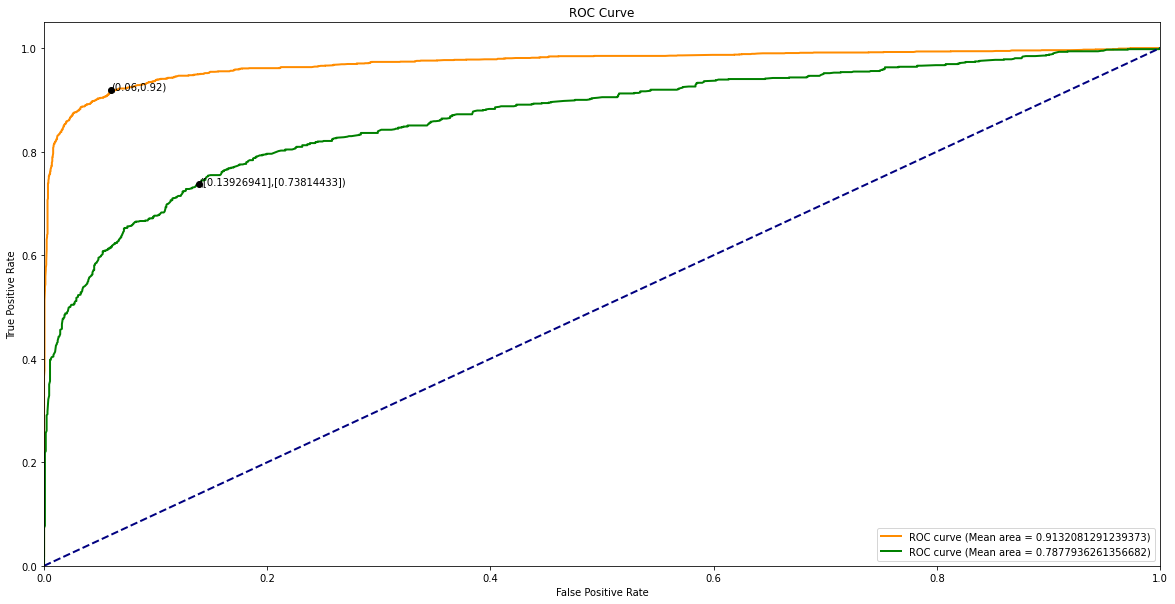

In [67]:
threshold = plot_roc_curve_mean(y_train=y_train.values, y_train_pred_proba=pred_proba_train, 
                        y_test=y_val.values, y_test_pred_proba=pred_proba_val)

## Test

In [68]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 2s 73ms/step - loss: 0.5029 - accuracy: 0.7782


[0.5029454827308655, 0.778215229511261]

In [69]:
pred_proba_test = model.predict(X_test).reshape(-1)
pred_proba_test = (pred_proba_test > threshold).astype(int)

array([[384.,  63.],
       [108., 207.]])

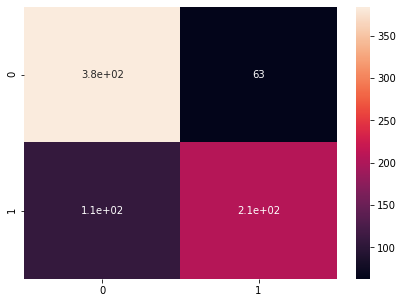

In [70]:
get_categorial_confusion_matrix(y_test, pred_proba_test, display=True)

# Predict

In [71]:
predictions = model.predict(test_data)
predictions = (predictions > threshold).astype(int)

In [72]:
output = pd.read_csv(PATH_RAW + 'sample_submission.csv')
output['target'] = predictions
output.to_csv(PATH_PROCESSED + 'to_submit.csv', index=False)